# This plots sigma for ICON IVM and GOLD in the same plot.

Found 328 files in the directory.
Shape of nmax array: (36, 100, 92)
UT time: 2022-02-07 23:36:21.984943
Longitude at UT 2022-02-07T23:10:00: 294.4609375
UT time: 2022-02-07 23:36:21.984943
Longitude at UT 2022-02-07T23:30:00: 294.4609375


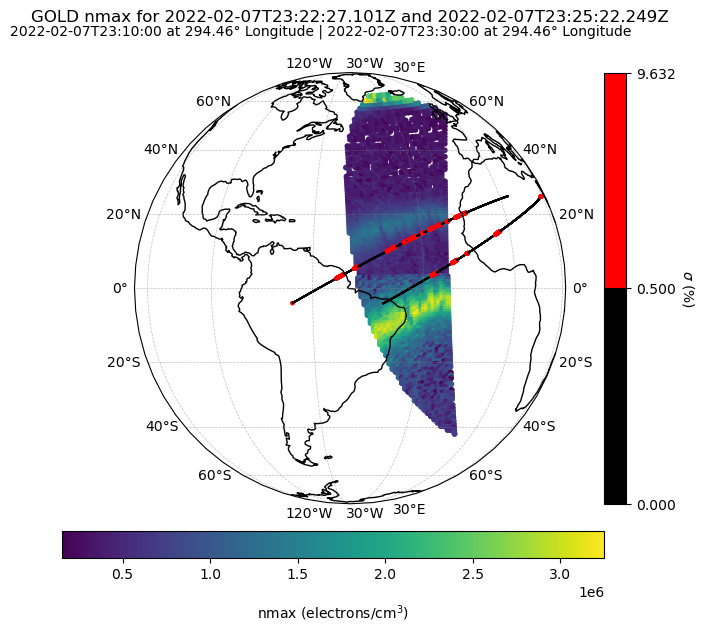

In [53]:
import numpy as np
import pandas as pd
import netCDF4
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import os
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from datetime import datetime
from netCDF4 import Dataset


# Function to load data from NetCDF files (IVM Data) with time range filtering
def load_data(file_path, start_time=None, end_time=None):
    try:
        with Dataset(file_path, 'r') as ncfile:
            vars_to_extract = [
                'ICON_L27_Ion_Density',
                'ICON_L27_UTC_Time',
                'ICON_L27_Latitude',
                'ICON_L27_Longitude',
                'ICON_L27_Solar_Local_Time'
            ]
            # Create a dictionary to hold the data
            data = {var: ncfile.variables[var][:] for var in vars_to_extract}

            # Convert the dictionary to a pandas DataFrame
            df = pd.DataFrame(data)

            # Check if the data is bytes and decode, otherwise convert directly to string
            utc_time_data = df['ICON_L27_UTC_Time']
            if isinstance(utc_time_data[0], bytes):
                utc_time_strings = [x.decode('utf-8') for x in utc_time_data]
            else:
                utc_time_strings = [str(x) for x in utc_time_data]

            # Replace 'Z' and 'T' with appropriate characters for datetime parsing
            df['ICON_L27_UTC_Time'] = pd.to_datetime(utc_time_strings).tz_localize(None)

            # Filter by the provided time range if start_time and end_time are specified
            if start_time and end_time:
                # Ensure that start_time and end_time are also Timestamp objects
                start_time = pd.to_datetime(start_time).tz_localize(None)
                end_time = pd.to_datetime(end_time).tz_localize(None)
                df = df[(df['ICON_L27_UTC_Time'] >= start_time) & (df['ICON_L27_UTC_Time'] <= end_time)]

            return df

    except Exception as e:
        print(f"An error occurred while processing the file {file_path}: {e}")
        return None


# Directory where the NetCDF files are stored (IVM Data)
directory_path = "/Users/gildagonzalez/Documents/Datos/ICON DATA/2022/"
file_paths = glob.glob(f'{directory_path}**/*.nc', recursive=True)

# Print the number of files found
print(f"Found {len(file_paths)} files in the directory.")

# Creating a custom colormap with discrete colors (for sigma)
colors = ['black', 'red']
cmap = LinearSegmentedColormap.from_list('custom', colors, N=2)
marker_choice = '.'

# Function to plot data for a range of dates and solar local times (for IVM data)
def plot_data_for_range(ax, start_date, end_date, solar_local_time_lower, solar_local_time_upper, specific_ut_times, start_time=None, end_time=None):
    longitudes_at_times = []
    times_at_longitudes = []
    
    for file_path in file_paths:
        file_date_str = os.path.basename(file_path).split('_')[3]
        file_date = pd.Timestamp(file_date_str).date()

        if file_date < start_date or file_date > end_date:
            continue

        df = load_data(file_path, start_time, end_time)
        if df is not None and not df.empty:
            df_filtered = df[
                (df['ICON_L27_Solar_Local_Time'] >= solar_local_time_lower) & 
                (df['ICON_L27_Solar_Local_Time'] <= solar_local_time_upper)
            ].copy()
            
            # Calculate the new metric for each 10-second segment
            segment_size = 10  # size of each segment in seconds
            num_segments = len(df_filtered) // segment_size
            new_metric = []

            for i in range(num_segments):
                segment = df_filtered.iloc[i*segment_size:(i+1)*segment_size]
                log_ion_density = np.log(segment['ICON_L27_Ion_Density'])
                std_dev = log_ion_density.std()
                mean_val = log_ion_density.mean()
            
                if mean_val != 0:
                    new_metric_value = (std_dev / mean_val) * 100 
                else:
                    new_metric_value = np.nan

                new_metric.extend([new_metric_value] * segment_size)

        # Add any remaining data points to the last segment
        last_segment = df_filtered.iloc[num_segments*segment_size:]
        if not last_segment.empty:
            log_ion_density = np.log(last_segment['ICON_L27_Ion_Density'])
            std_dev = log_ion_density.std()
            mean_val = log_ion_density.mean()

            if mean_val != 0:
                new_metric_value = (std_dev / mean_val) * 100  
            else:
                new_metric_value = np.nan

            new_metric.extend([new_metric_value] * len(last_segment))

        # Add the new metric to the dataframe
        df_filtered['New_Metric'] = new_metric
                            
         # Loop through each specific UT time to get the corresponding longitude
        for specific_ut_time in specific_ut_times:
             # Convert the string to a pandas Timestamp object
            specific_ut_time_obj = pd.to_datetime(specific_ut_time)
             # Find the absolute difference between each time and the desired one
            differences = np.abs(df_filtered['ICON_L27_UTC_Time'] - specific_ut_time_obj)
            # Find the index of the smallest difference
            idx_closest_time = differences.argmin()
            # Retrieve the longitude at the closest time
            closest_longitude = df_filtered.iloc[idx_closest_time]['ICON_L27_Longitude']
            # Append the found longitude and the time to the list
            times_at_longitudes.append((closest_longitude, specific_ut_time))
            # Get the closest UT value for verification
            closest_time = df_filtered.iloc[idx_closest_time]['ICON_L27_UTC_Time']
            # Get the corresponding longitude
            longitude_at_specific_ut = df_filtered.iloc[idx_closest_time]['ICON_L27_Longitude']
            # Append the result to your list
            longitudes_at_times.append((specific_ut_time, longitude_at_specific_ut))
            # Print the information for verification
            print(f"UT time: {closest_time}")
            print(f"Longitude at UT {specific_ut_time}: {longitude_at_specific_ut}")


            # Outside the loop, set the title and subtitle
            if not df_filtered.empty:
                ax.set_title(f'GOLD nmax for {time_string}', pad=20)
                # Construct the subtitle with both UT times at the specified longitudes
                subtitle = ' | '.join([f'UT at {lon}° Longitude: {time}' for lon, time in times_at_longitudes])
                plt.suptitle(subtitle, fontsize=10, y=0.95)  # Adjust y as needed

                
            # Define sizes and colors based on the new metric
            is_blue = df_filtered['New_Metric'] <= 0.5  # 0.3% threshold
            sizes = np.where(is_blue, 0.5, 20)  # smaller size for 'blue', larger for 'not blue'

            # Define the normalization for colormap based on data boundaries
            max_val = np.nanmax(df_filtered['New_Metric'])  # compute the max ignoring NaN values
            
                # Ensure boundaries are monotonically increasing
            if max_val > 0.5:
                boundaries = [0, 0.5, max_val]
            else:
                boundaries = [0, max_val]

            norm = BoundaryNorm(boundaries, cmap.N)


            # Plotting the data points
            scatter = ax.scatter(
                df_filtered['ICON_L27_Longitude'], df_filtered['ICON_L27_Latitude'], 
                c=df_filtered['New_Metric'], cmap=cmap, norm=norm, 
                s=sizes, marker=marker_choice, transform=ccrs.PlateCarree()
            )

        # Display color bar for the new metric
        cbar = plt.colorbar(scatter, orientation='vertical', ax=ax)
        cbar.set_label(r'$\sigma$ (%)', rotation=270, labelpad=15)

        plt.title(f'Sigma for {os.path.basename(file_path)}')

    return longitudes_at_times

# Path to the netCDF file (GOLD Data)
path = '/Users/gildagonzalez/Documents/Datos/STD/GOLD/Feb_2022/GOLD_L2_NMAX_2022_038_v03_r01_c01.nc'

# Load the netCDF data (GOLD)
dataset = netCDF4.Dataset(path)
nmax = dataset.variables['nmax'][:]
latitude = dataset.variables['latitude'][:]
longitude = dataset.variables['longitude'][:]
time_utc = dataset.variables['time_utc'][:]
dqi = dataset.variables['dqi'][:]

# Print the shape of the nmax array to check the number of slices
print("Shape of nmax array:", nmax.shape)

# Define the specific slice indices you want to plot
slice_indices = [26, 27,]  # Slice indices, it is posible to add more indices to plot more UTs

# Initialize a list to store time strings and create the plot
time_strings = []
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.Orthographic(central_longitude=-50, central_latitude=0)})
ax.set_global()
ax.coastlines(resolution='110m')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Plot each slice
for slice_idx in slice_indices:
    nmax_slice = nmax[slice_idx,:,:]
    latitude_slice = latitude[slice_idx,:,:]
    longitude_slice = longitude[slice_idx,:,:]
    time_string = time_utc[slice_idx, 0, :].tobytes().decode('utf-8').strip()
    time_string = ''.join(filter(str.isprintable, time_string))

    # Add the cleaned time string to our list
    time_strings.append(time_string)

    # Here we filter the valid data for the current slice
    valid_mask = ~np.isnan(nmax_slice)  # Mask to filter valid nmax data points
    valid_nmax = nmax_slice[valid_mask]
    valid_lats = latitude_slice[valid_mask]
    valid_lons = longitude_slice[valid_mask]

    # Plot the second slice for GOLD
    sc = ax.scatter(valid_lons, valid_lats, c=valid_nmax, cmap='viridis', s=10, 
                    transform=ccrs.PlateCarree())

# Assuming we have two time strings, we combine them in the title
combined_time_string = ' and '.join(time_strings)
ax.set_title(f'GOLD nmax for {combined_time_string}', pad=25)

sc = ax.scatter(valid_lons, valid_lats, c=valid_nmax, cmap='viridis', s=10, transform=ccrs.PlateCarree(),
                vmin=valid_nmax.min(), vmax=valid_nmax.max())
cbar1 = plt.colorbar(sc, ax=ax, label='nmax (electrons/cm$^3$)', orientation='horizontal', pad=0.05, shrink=0.7, aspect=20)
cbar1.set_label('nmax (electrons/cm$^3$)', rotation=0, labelpad=15)

# Define the specific UT times and time range to find the longitudes
specific_ut_times = ['2022-02-07T23:10:00', '2022-02-07T23:30:00'] 
time_range_start = '2022-02-07T22:00:00'
time_range_end = '2022-02-07T23:59:00'

# Overlay the data from ICON on the GOLD plot
longitudes_at_times = plot_data_for_range(ax, pd.Timestamp('2022-02-07').date(), pd.Timestamp('2022-02-07').date(), 19, 24, specific_ut_times, time_range_start, time_range_end)

# Set the title for the GOLD data
ax.set_title(f'GOLD nmax for {time_string}', pad=25)

file_date_str = '20220207' 


# Define the directory to save the plot
save_directory = '/Users/gildagonzalez/Documents/Datos/STD/SIGMA/GOLD+ICON'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Define the filename for the plot, using the date from the NetCDF file
# Assuming we have two time strings, combine them in the title and set it
#combined_time_string = ' and '.join(time_strings)
filename = f'GOLD_ICON_{file_date_str}.png' 

ax.set_title(f'GOLD nmax for {combined_time_string}', pad=25)

# After plotting your data and before showing or saving the figure
subtitle_text = ' | '.join([f'{time} at {lon:.2f}° Longitude' for time, lon in longitudes_at_times])
plt.suptitle(subtitle_text, fontsize=10, y=0.95) 

# Full path to save the plot
save_path = os.path.join(save_directory, filename)

# Save the plot
plt.savefig(save_path, bbox_inches='tight')

# Show the plot
plt.show()